## Final Project Submission

Please fill out:
* Student name: Kregg Jackson 
* Student pace: self paced
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@kr3ggjac.cj/data-science-effect-on-professional-sports-b11d3dc3e350


# Kansas City House Data Analysis
## Project Goal
With analysis of each column’s relationship with price I can suggest what renovations have the greatest impact on sales.


In [49]:
# Imports
import pandas as pd
import os,glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
# Reading csv file
kc_house_data = pd.read_csv('/Users/kregg/dsc-phase-2-project/data/kc_house_data.csv', index_col=0)
kc_house_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
kc_house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  object 
 8   view           21534 non-null  object 
 9   condition      21597 non-null  object 
 10  grade          21597 non-null  object 
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

### Test for which predictor has highest correlation with dependent variable and build baseline model

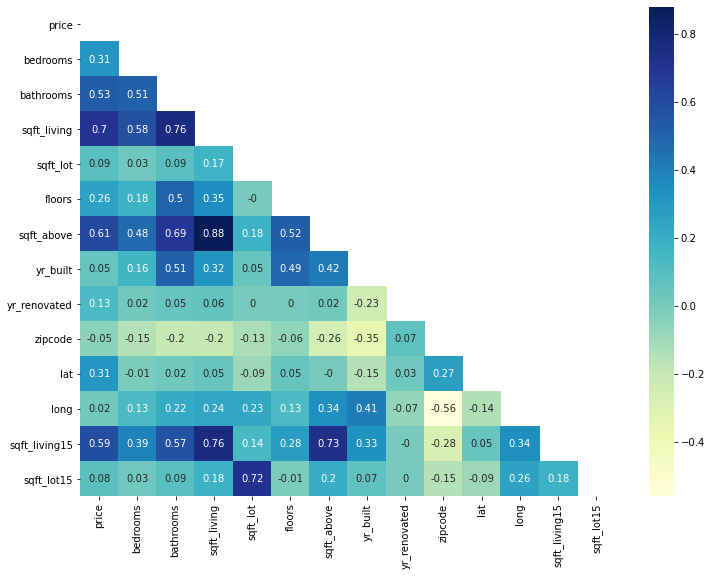

In [4]:
corrprice = kc_house_data.corr().round(2)
mask = np.zeros_like(corrprice)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12,9))
sns.heatmap(corrprice,annot=True,cmap="YlGnBu",mask=mask);

The highest correlated predictors are `sqft_living`, `sqft_above`, and `sqft_living_15`. The variables that can be renovated reasonably are `bathrooms` and `bedrooms`.

In [5]:
kc_house_data['sqft_living'].isnull().sum()

0

In [6]:
#baseline model
baseX = kc_house_data['sqft_living']
y = kc_house_data['price']
baseX = sm.add_constant(baseX) 
baselinemodel = sm.OLS(y, baseX).fit()
baselinemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:48:04   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

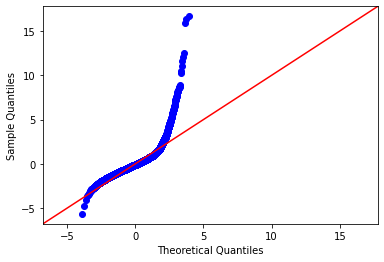

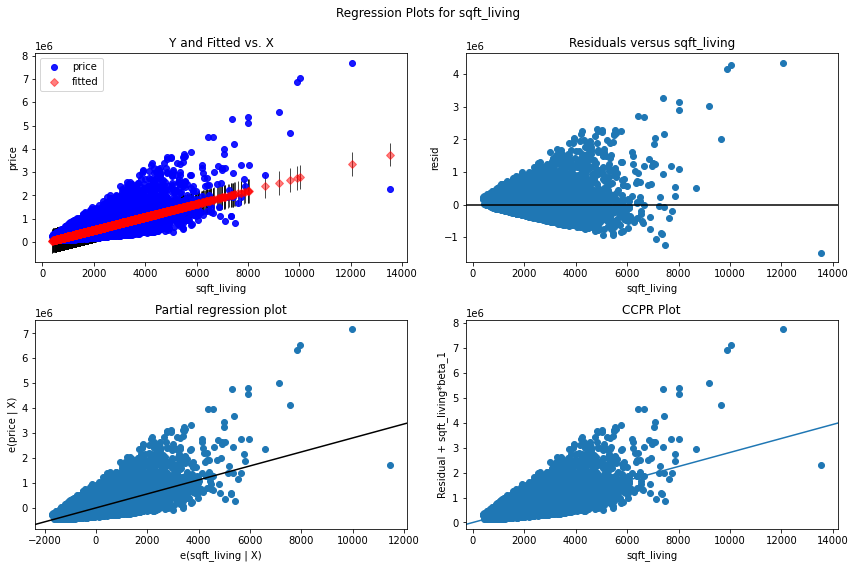

In [7]:
sm.graphics.qqplot(baselinemodel.resid, line='45',fit=True);
sm.graphics.plot_regress_exog(baselinemodel, 'sqft_living', fig=plt.figure(figsize=(12,8)));

### Baseline Model:
The baseline model’s high R squared and low p -value showed that there is a relationship between price and sqft_living. The scatter plots are very heteroscedastic and the Q-Q plot shows the model is not doing a good job predicting the price. However this model is inconclusive because there is not predictors and sqft_living is too highly correlated with the other predictors. My next step is to clean the database and build a model out of the rest of the predictors.

### Data cleaning and EDA

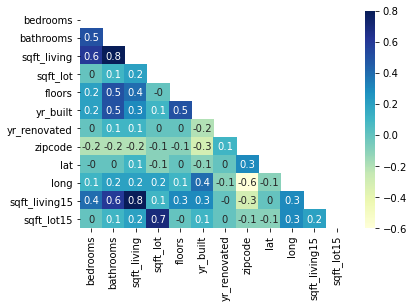

In [8]:
corr = kc_house_data.drop(['price','sqft_above'],axis=1).corr().round(1)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr,annot=True,cmap="YlGnBu",mask=mask);

Testing for multicollinearity among predictors I choses to drop `sqft_above` because it was too correlated with the other predictors.

In [9]:
kc_house_data.drop(['lat', 'long', 'yr_renovated', 'date', 'sqft_above'], axis=1, inplace=True)

/Users/kregg/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


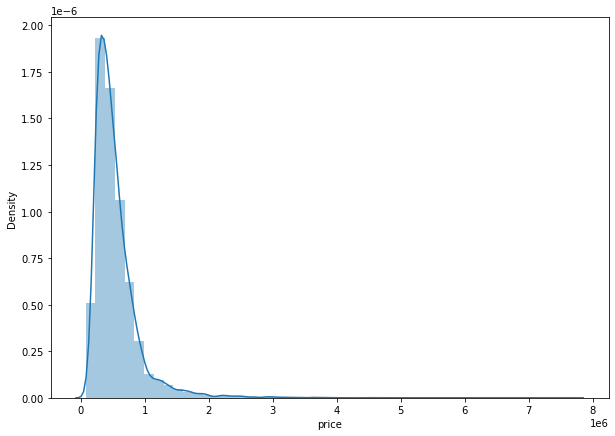

In [10]:
plt.figure(figsize=(10,7))
sns.distplot(kc_house_data['price']);

The `price` column data is skewed to the lower side most likely because of large outliers.

In [11]:
kc_house_data['bathrooms'].describe()

count    21597.000000
mean         2.115826
std          0.768984
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

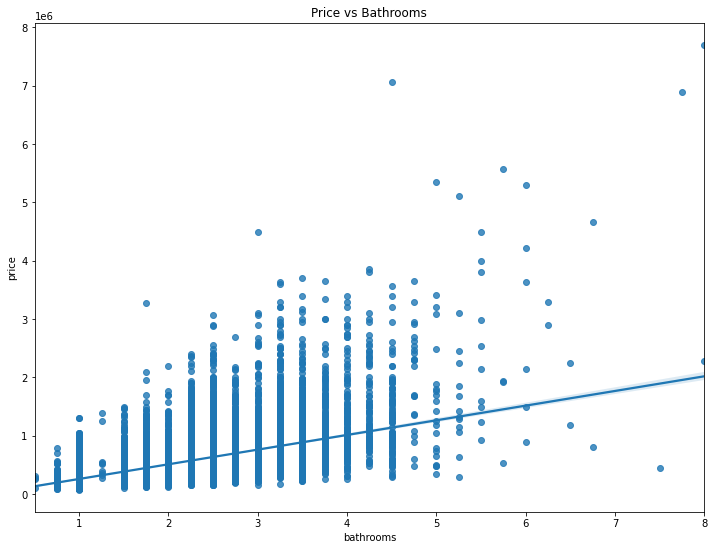

In [74]:
plt.figure(figsize=(12,9))
plt.title('Price vs Bathrooms')
sns.regplot(data=kc_house_data, x = kc_house_data['bathrooms'], 
            y=kc_house_data['price']);

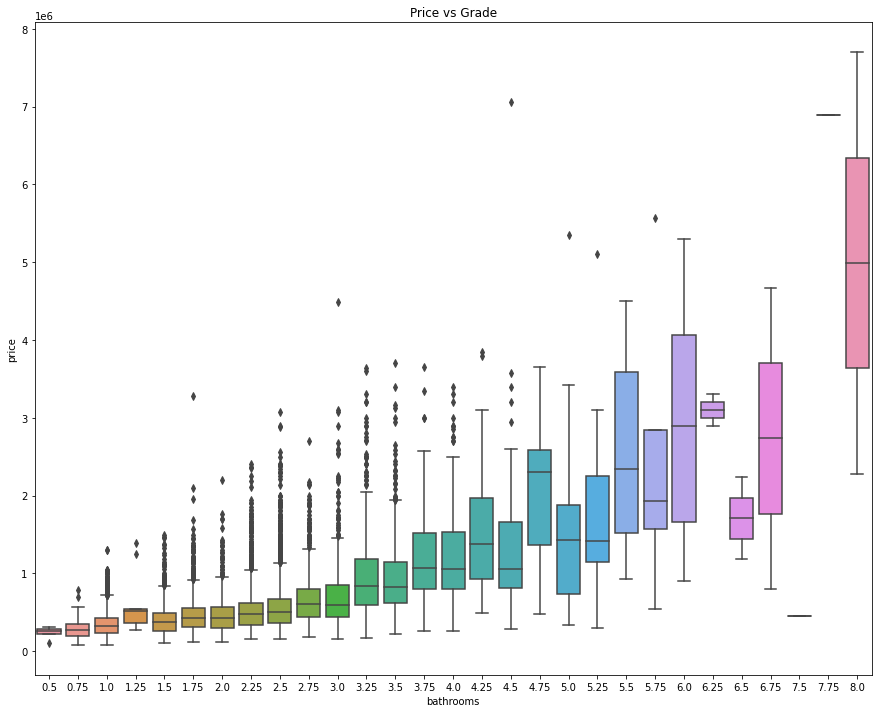

In [82]:
plt.figure(figsize=(15,12))
plt.title('Price vs Grade')
bathroom_box = sns.boxplot(x= kc_house_data['bathrooms'], y= kc_house_data['price']);

The `bahtrooms` data looks normal for the most part with some outliers. There are a lot of data points in `bathrooms`, while I was familiar with half baths I had never heard of a quarter bath before.

In [13]:
kc_house_data['bedrooms'].describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

In [14]:
kc_house_data['bedrooms'].sort_values()

id
1231000310     1
2658000115     1
1523300180     1
2009003136     1
1154100205     1
              ..
5566100170    10
627300145     10
8812401450    10
1773100755    11
2402100895    33
Name: bedrooms, Length: 21597, dtype: int64

In [15]:
kc_house_data.shape

(21597, 15)

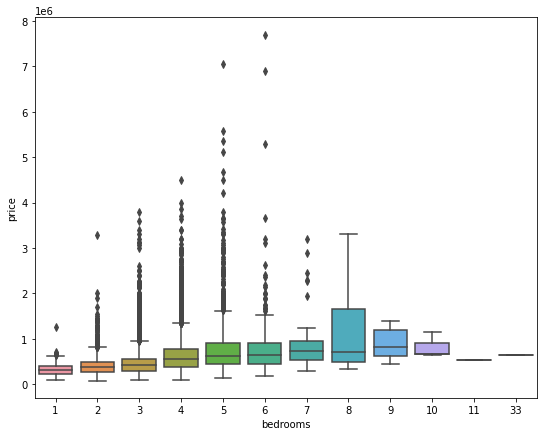

In [16]:
plt.figure(figsize=(9,7))
sns.boxplot(x= kc_house_data['bedrooms'], 
            y= kc_house_data['price']);

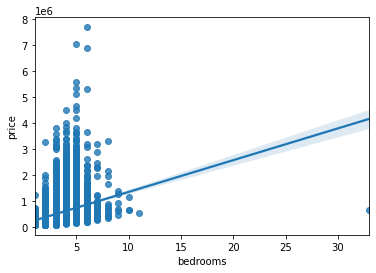

In [17]:
sns.regplot(data=kc_house_data, x = kc_house_data['bedrooms'], 
            y=kc_house_data['price']);

The `bedrooms` column has a large outlier of a property with 33 bedrooms three times larger than what would be the max if the dataframe did not include this house. I am going to drop the 33 bedroom property because it is such a large outlier.

In [18]:
bedroom_outlier = kc_house_data[(kc_house_data['bedrooms'] > 30)].index
kc_house_data.drop(bedroom_outlier, inplace = True)

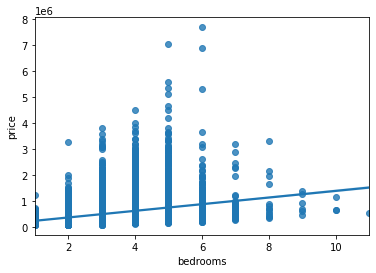

In [19]:
sns.regplot(data=kc_house_data, x = kc_house_data['bedrooms'], 
            y=kc_house_data['price']);

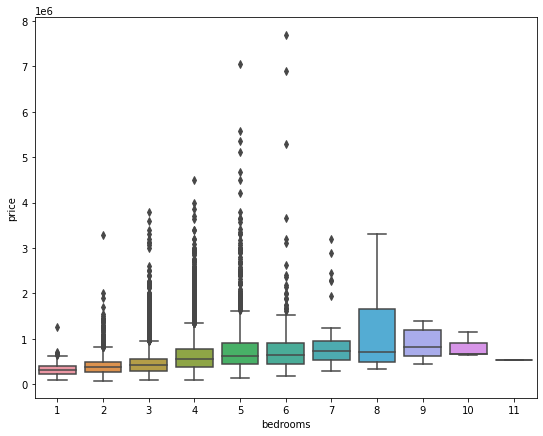

In [20]:
plt.figure(figsize=(9,7))
sns.boxplot(x= kc_house_data['bedrooms'], 
            y= kc_house_data['price']);

Boxplot and regplot look much better after dropping the 33 bedroom property. Still some large outliers but I don't want to drop too much data.

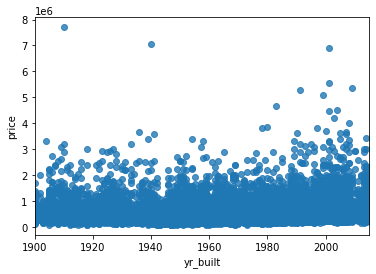

In [21]:
sns.regplot(data=kc_house_data, x = kc_house_data['yr_built'], 
            y=kc_house_data['price']);

The `yr_built` data looks homoscedastic and pretty evenly distributed with some outliers.

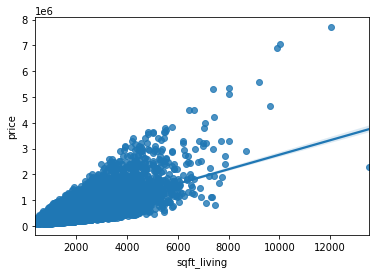

In [22]:
sns.regplot(data=kc_house_data, x = kc_house_data['sqft_living'], 
            y=kc_house_data['price']);

The `sqft_living` column like the `yr_built` is mainly homoscedastic with a few outliers. Too many outliers could skew the data and make the model less accurate.

In [23]:
kc_house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 7129300520 to 1523300157
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21596 non-null  float64
 1   bedrooms       21596 non-null  int64  
 2   bathrooms      21596 non-null  float64
 3   sqft_living    21596 non-null  int64  
 4   sqft_lot       21596 non-null  int64  
 5   floors         21596 non-null  float64
 6   waterfront     19220 non-null  object 
 7   view           21533 non-null  object 
 8   condition      21596 non-null  object 
 9   grade          21596 non-null  object 
 10  sqft_basement  21596 non-null  object 
 11  yr_built       21596 non-null  int64  
 12  zipcode        21596 non-null  int64  
 13  sqft_living15  21596 non-null  int64  
 14  sqft_lot15     21596 non-null  int64  
dtypes: float64(3), int64(7), object(5)
memory usage: 3.3+ MB


In [24]:
kc_house_data['sqft_basement'] = kc_house_data['sqft_basement'].replace('?', np.NaN).astype(float)
kc_house_data['sqft_basement'].fillna(0, inplace=True)
kc_house_data.dtypes

price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
view              object
condition         object
grade             object
sqft_basement    float64
yr_built           int64
zipcode            int64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [59]:
kc_house_data['price'].describe().round(0)

count      21596.0
mean      540292.0
std       367376.0
min        78000.0
25%       322000.0
50%       450000.0
75%       645000.0
max      7700000.0
Name: price, dtype: float64

In [25]:
kc_house_data['condition'].value_counts()

Average      14020
Good          5677
Very Good     1700
Fair           170
Poor            29
Name: condition, dtype: int64

In [26]:
kc_house_data['price'].groupby(kc_house_data['bathrooms']).describe().round(1)

,count,mean,std,min,25%,50%,75%,max
bathrooms,,,,,,,,
0.50,4.0,237375.0,88888.9,109000.0,218500.0,264000.0,282875.0,312500.0
0.75,71.0,294936.6,139022.0,80000.0,201000.0,275000.0,355000.0,785000.0
1.00,3851.0,347072.1,154567.4,78000.0,230000.0,320000.0,425000.0,1300000.0
1.25,9.0,621772.2,408881.7,275000.0,360000.0,516500.0,545000.0,1390000.0
1.50,1445.0,409429.7,193930.7,107000.0,265950.0,370000.0,495800.0,1500000.0
1.75,3047.0,454855.1,202054.5,115000.0,310000.0,422800.0,555000.0,3280000.0
2.00,1930.0,457905.0,206072.3,115000.0,300500.0,423250.0,563000.0,2200000.0
2.25,2047.0,533768.8,281159.7,160000.0,339975.0,472500.0,625000.0,2400000.0
2.50,5377.0,553803.3,267071.2,153503.0,365000.0,499950.0,675000.0,3070000.0


In [27]:
kc_house_data.replace({
    'grade':'[A-Za-z]'},'',regex=True, inplace= True)
kc_house_data['grade'] = kc_house_data['grade'].astype(float)

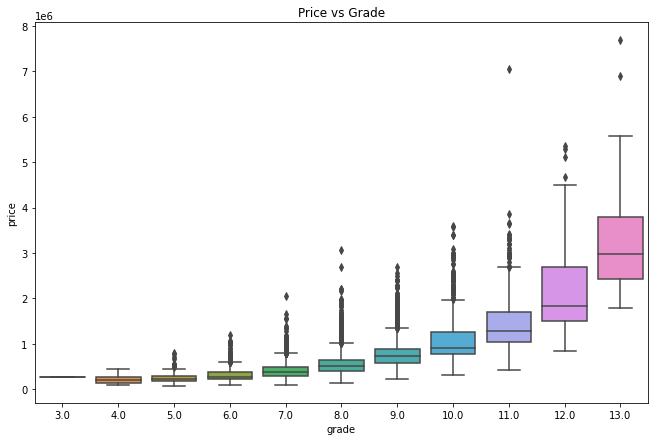

In [66]:
plt.figure(figsize=(11,7))
plt.title('Price vs Grade')
sns.boxplot(x= kc_house_data['grade'], y= kc_house_data['price']);

The data in the `grade` column looks normal and can be analyzed now that the strings in the grade column are gone.

In [29]:
kc_house_data['waterfront'].fillna('NO', inplace=True)
kc_house_data['view'].fillna('NONE', inplace=True)
kc_house_data.shape

(21596, 15)

In [30]:
kc_house_data.describe().round(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
count,21596.00,21596.00,21596.00,21596.00,21596.00,21596.00,21596.00,21596.00,21596.00,21596.00,21596.00,21596.00
mean,540291.96,3.37,2.12,2080.34,15099.83,1.49,7.66,285.70,1971.00,98077.95,1986.65,12758.66
std,367376.02,0.90,0.77,918.12,41413.55,0.54,1.17,439.83,29.38,53.51,685.23,27275.02
min,78000.00,1.00,0.50,370.00,520.00,1.00,3.00,0.00,1900.00,98001.00,399.00,651.00
25%,322000.00,3.00,1.75,1430.00,5040.00,1.00,7.00,0.00,1951.00,98033.00,1490.00,5100.00
50%,450000.00,3.00,2.25,1910.00,7619.00,1.50,7.00,0.00,1975.00,98065.00,1840.00,7620.00
75%,645000.00,4.00,2.50,2550.00,10685.50,2.00,8.00,550.00,1997.00,98118.00,2360.00,10083.00
max,7700000.00,11.00,8.00,13540.00,1651359.00,3.50,13.00,4820.00,2015.00,98199.00,6210.00,871200.00


In [31]:
kc_house_data.nunique()

price            3622
bedrooms           11
bathrooms          29
sqft_living      1034
sqft_lot         9776
floors              6
waterfront          2
view                5
condition           5
grade              11
sqft_basement     303
yr_built          116
zipcode            70
sqft_living15     777
sqft_lot15       8682
dtype: int64

In [32]:
# One hot encoding categorical variables
kc_house_data_dummies = pd.get_dummies(kc_house_data, columns=['waterfront', 'view', 'condition'], drop_first=True)
kc_house_data_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_basement,yr_built,zipcode,...,sqft_lot15,waterfront_YES,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,condition_Good,condition_Poor,condition_Very Good
id,,,,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,7.0,0.0,1955,98178,...,5650,0,0,0,0,1,0,0,0,0
6414100192,538000.0,3,2.25,2570,7242,2.0,7.0,400.0,1951,98125,...,7639,0,0,0,0,1,0,0,0,0
5631500400,180000.0,2,1.00,770,10000,1.0,6.0,0.0,1933,98028,...,8062,0,0,0,0,1,0,0,0,0
2487200875,604000.0,4,3.00,1960,5000,1.0,7.0,910.0,1965,98136,...,5000,0,0,0,0,1,0,0,0,1
1954400510,510000.0,3,2.00,1680,8080,1.0,8.0,0.0,1987,98074,...,7503,0,0,0,0,1,0,0,0,0


### Build first model

In [33]:
kc_house_data.reset_index(drop = True)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NO,NONE,Average,7.0,0.0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7.0,400.0,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6.0,0.0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7.0,910.0,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8.0,0.0,1987,98074,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8.0,0.0,2009,98103,1530,1509
21592,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8.0,0.0,2014,98146,1830,7200
21593,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7.0,0.0,2009,98144,1020,2007
21594,400000.0,3,2.50,1600,2388,2.0,NO,NONE,Average,8.0,0.0,2004,98027,1410,1287


In [34]:
X = kc_house_data_dummies.drop('price', axis=1)

In [35]:
X = sm.add_constant(X)

In [36]:
y1 = kc_house_data['price']

In [37]:
firstmodel = sm.OLS(y1, X).fit()

In [38]:
firstmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     2065.
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:48:24   Log-Likelihood:            -2.9583e+05
No. Observations:               21596   AIC:                         5.917e+05
Df Residuals:                   21575   BIC:                         5.919e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                9.217e+06   3.13e+06      2.948      0.003    3.09e+06    1.53e+07
bedrooms            -4.319e+04   2116.948    -20.402      0.000   -4.73e+04    -3.9e+04
bathrooms            4.795e+04   3473.770     13.804      0.000    4.11e+04    5.48e+04
sqft_living           161.4337      3.900     41.396      0.000     153.790     169.078
sqft_lot                0.0037      0.051      0.072      0.943      -0.097       0.104
floors               2.805e+04   3814.276      7.355      0.000    2.06e+04    3.55e+04
grade                1.206e+05   2260.715     53.364      0.000    1.16e+05    1.25e+05
sqft_basement           7.9696      4.534      1.758      0.079      -0.917      16.856
yr_built            -3662.3509     71.123    -51.494      0.000   -3801.756   -3522.945
zipcode               -27.8387     31.403     -0.886      0.375     -89.391      33.714
sqft_living15          24.0042      3.639      6.597      0.000      16.872      31.137
sqft_lot15             -0.5522      0.078     -7.061      0.000      -0.705      -0.399
waterfront_YES       5.272e+05   2.18e+04     24.178      0.000    4.84e+05     5.7e+05
view_EXCELLENT       2.341e+05   1.63e+04     14.349      0.000    2.02e+05    2.66e+05
view_FAIR            5.623e+04   1.38e+04      4.086      0.000    2.93e+04    8.32e+04
view_GOOD            5.917e+04   1.19e+04      4.985      0.000    3.59e+04    8.24e+04
view_NONE           -4.878e+04   7352.763     -6.635      0.000   -6.32e+04   -3.44e+04
condition_Fair      -3568.5555   1.68e+04     -0.213      0.831   -3.64e+04    2.93e+04
condition_Good       1.131e+04   3687.691      3.067      0.002    4081.673    1.85e+04
condition_Poor      -7961.9140   4.02e+04     -0.198      0.843   -8.68e+04    7.08e+04
condition_Very Good  4.726e+04   5894.687      8.017      0.000    3.57e+04    5.88e+04
==============================================================================
Omnibus:                    16247.939   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1187145.922
Skew:                           3.009   Prob(JB):                         0.00
Kurtosis:                      38.820   Cond. No.                     2.15e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

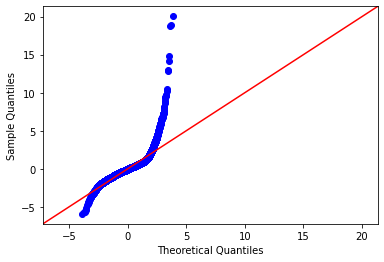

In [39]:
sm.graphics.qqplot(firstmodel.resid, line='45',fit=True);

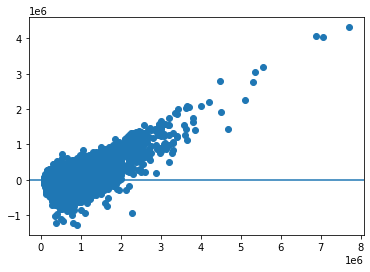

In [40]:
plt.scatter(kc_house_data['price'],firstmodel.resid)
plt.axhline(0);

## First model:
The first model has a high R-squared of 0.891 and low p-values on most of the predictors. The scatter plot is still too heteroscedastic and the Q-Q plot still shows that the data is not normally distributed and the model is not doing a good job of predicting values. My next steps are to build a new model with none of the predictors with high p-values and use the log of the dependent variable to normalize the data. 

### Build Final model

In [41]:
# Remove high p values and add constant
X.drop(['sqft_basement','sqft_lot','condition_Fair','condition_Good','condition_Poor','condition_Very Good', 'zipcode'], axis=1, inplace = True)

In [42]:
predictors = sm.add_constant(X)

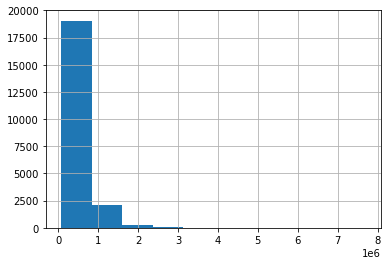

In [43]:
#not normally distributed
y1.hist();

The `price` column data is skewed to the left. This may cause bias in the model so I am going to buuld a model with the log of the `price` data. I am going to log transform the dependent variable to address assumptions and make sure they look normal.

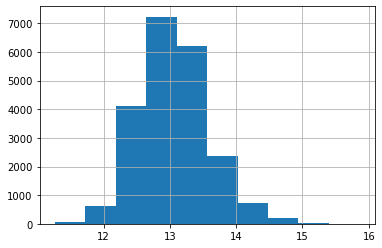

In [44]:
# log transform
y_scld = np.log(y1)
y_scld.hist();

After getting the log of the `price` column data it is normally distributed.

In [45]:
logmodel = sm.OLS(y_scld, predictors).fit()
logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     3084.
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:48:25   Log-Likelihood:                -5454.1
No. Observations:               21596   AIC:                         1.094e+04
Df Residuals:                   21582   BIC:                         1.105e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.6713      0.176    129.038      0.000      22.327      23.016
bedrooms          -0.0241      0.003     -7.883      0.000      -0.030      -0.018
bathrooms          0.0956      0.005     19.343      0.000       0.086       0.105
sqft_living        0.0001    5.2e-06     25.067      0.000       0.000       0.000
floors             0.0833      0.005     16.951      0.000       0.074       0.093
grade              0.2042      0.003     62.950      0.000       0.198       0.211
yr_built          -0.0060   9.31e-05    -64.376      0.000      -0.006      -0.006
sqft_living15   9.487e-05   5.09e-06     18.643      0.000    8.49e-05       0.000
sqft_lot15     -3.791e-07   8.03e-08     -4.721      0.000   -5.37e-07   -2.22e-07
waterfront_YES     0.3176      0.032     10.068      0.000       0.256       0.379
view_EXCELLENT     0.1438      0.024      6.102      0.000       0.098       0.190
view_FAIR          0.0822      0.020      4.131      0.000       0.043       0.121
view_GOOD          0.0261      0.017      1.520      0.128      -0.008       0.060
view_NONE         -0.0879      0.011     -8.318      0.000      -0.109      -0.067
==============================================================================
Omnibus:                      112.741   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.160
Skew:                          -0.147   Prob(JB):                     4.90e-27
Kurtosis:                       3.219   Cond. No.                     2.50e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

On the final model the R-squared score dropped to 0.650 but most the predictors have a low p-value. The `view_GOOD` column does have a high p-value but since it is apart of a one hot encoded variable I am going to leave it in because the other elements have low p-values and are highly correlated with the price.

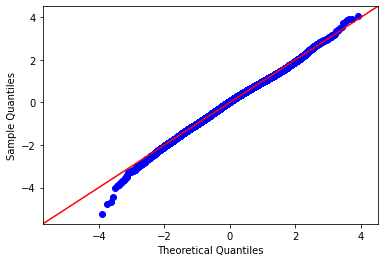

In [46]:
sm.graphics.qqplot(logmodel.resid, line='45',fit=True);

The points are finally close to the line meaning the model is doing a good job of predicting the values in the data. 

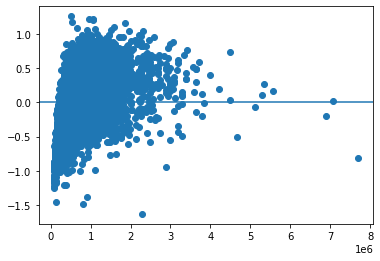

In [47]:
plt.scatter(kc_house_data['price'],logmodel.resid)
plt.axhline(0);
#Mainly homoscedastic return with few outliers

In [48]:
logmodel.params.sort_values().round(4)

view_NONE         -0.0879
bedrooms          -0.0241
yr_built          -0.0060
sqft_lot15        -0.0000
sqft_living15      0.0001
sqft_living        0.0001
view_GOOD          0.0261
view_FAIR          0.0822
floors             0.0833
bathrooms          0.0956
view_EXCELLENT     0.1438
grade              0.2042
waterfront_YES     0.3176
const             22.6713
dtype: float64

## Final model:
On the final model the R-squared score dropped to 0.650 but most the predictors have a low p-value. The Q-Q plot shows the model is normally distributed and the scatter plot shows the data is homooscedastic. 

# Conclusion

* Based on the coefficients of the final version of my model the `waterfront_YES`  column has the strongest positive impact on price 
* The coefficient is 0.3189 which means if the house is waterfront property the price should be 31.89% higher than if it was not waterfront 
* The `grade` column was the second highest coefficient, if the grade goes up a point the house value increases by 20.47%. I'd recommend renovators buy a house with a low grade because after renovating the property the grade will likely increase and each point is worth 20.47% of the house's sale price
* The `bathrooms` column was the highest correlated column that could be practically renovated, adding a bathroom could increase house value by 9.5% 
* Based on the coefficients I would advise against adding a bedroom as according to the `bedrooms` column adding a bedroom could reduce the value of the house by 2.41%. If renovators were faced with the decision of turning a spare room into a bedroom or bathroom I would recommend they convert the room to a bathroom.


### Next Steps

Clearly more hours of analysis could provide further insights into how to improve likelihood of renovation success.

Too many columns deal with factors that can’t be changed I would suggest building a regression model only out of columns with data that can be renovated. 

The `zipcode` column would better serve the model if it was replaced with a county column instead. County's could be one hot encoded and be easier for the model to interpret than zipcode.

If I had more time I would also remove more outliers to reduce error and get a more accurate model.